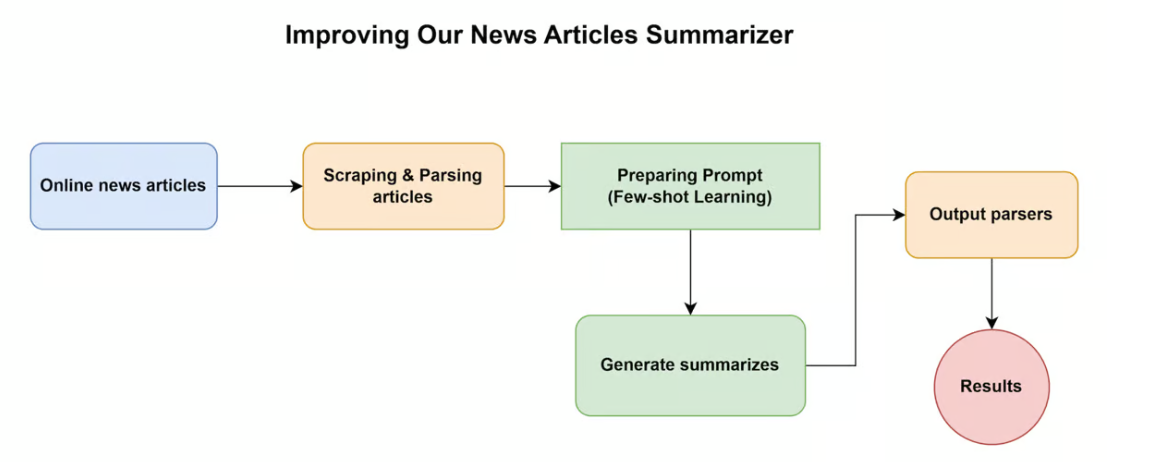

In [1]:
from dotenv import load_dotenv
import os

load_dotenv()
os.environ['OPENAI_API_KEY'] = os.environ.get("OPENAI_API_KEY")

In [3]:
import requests
from newspaper import Article

headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/89.0.4389.82 Safari/537.36'
}

article_url = "https://www.artificialintelligence-news.com/2022/01/25/meta-claims-new-ai-supercomputer-will-set-records/"

session = requests.Session()


try:
    response = session.get(article_url, headers=headers, timeout=10)

    if response.status_code == 200:
        article = Article(article_url)
        article.download()
        article.parse()

        print(f"Title: {article.title}")
        print(f"Text: {article.text}")
    else:
        print(f"Failed to fetch article at {article_url}")
except Exception as e:
    print(f"Error occurred while fetching article at {article_url}: {e}")

Title: Meta claims its new AI supercomputer will set records
Text: Ryan is a senior editor at TechForge Media with over a decade of experience covering the latest technology and interviewing leading industry figures. He can often be sighted at tech conferences with a strong coffee in one hand and a laptop in the other. If it's geeky, he’s probably into it. Find him on Twitter (@Gadget_Ry) or Mastodon (@gadgetry@techhub.social)

Meta (formerly Facebook) has unveiled an AI supercomputer that it claims will be the world’s fastest.

The supercomputer is called the AI Research SuperCluster (RSC) and is yet to be fully complete. However, Meta’s researchers have already begun using it for training large natural language processing (NLP) and computer vision models.

RSC is set to be fully built in mid-2022. Meta says that it will be the fastest in the world once complete and the aim is for it to be capable of training models with trillions of parameters.

“We hope RSC will help us build entire

In [4]:
from langchain.schema import (
    HumanMessage
)

# we get the article data from the scraping part
article_title = article.title
article_text = article.text

# prepare template for prompt
template = """
As an advanced AI, you've been tasked to summarize online articles into bulleted points. Here are a few examples of how you've done this in the past:

Example 1:
Original Article: 'The Effects of Climate Change
Summary:
- Climate change is causing a rise in global temperatures.
- This leads to melting ice caps and rising sea levels.
- Resulting in more frequent and severe weather conditions.

Example 2:
Original Article: 'The Evolution of Artificial Intelligence
Summary:
- Artificial Intelligence (AI) has developed significantly over the past decade.
- AI is now used in multiple fields such as healthcare, finance, and transportation.
- The future of AI is promising but requires careful regulation.

Now, here's the article you need to summarize:

==================
Title: {article_title}

{article_text}
==================

Please provide a summarized version of the article in a bulleted list format.
"""

# format prompt
prompt = template.format(article_title=article.title, article_text=article.text)

messages = [HumanMessage(content=prompt)]

In [6]:
from langchain_openai import ChatOpenAI

# load the model
chat = ChatOpenAI(model_name="gpt-4", temperature=0)

In [7]:
# generate summary
summary = chat.invoke(messages)

content="- Meta (formerly Facebook) has announced an AI supercomputer, the AI Research SuperCluster (RSC), which it claims will be the world's fastest.\n- The supercomputer is not yet fully built, but is already being used by Meta's researchers for training large natural language processing and computer vision models.\n- The RSC is expected to be fully operational by mid-2022 and aims to train models with trillions of parameters.\n- Meta hopes the RSC will help build new AI systems for real-time voice translations and other applications, paving the way for the next major computing platform, the metaverse.\n- Once complete, RSC is expected to be 20x faster than Meta's current V100-based clusters, 9x faster at running the NVIDIA Collective Communication Library, and 3x faster at training large-scale NLP workflows.\n- A model with tens of billions of parameters can finish training in three weeks with RSC, compared to nine weeks previously.\n- The RSC was designed with security and privacy

In [8]:
print(summary.content)

- Meta (formerly Facebook) has announced an AI supercomputer, the AI Research SuperCluster (RSC), which it claims will be the world's fastest.
- The supercomputer is not yet fully built, but is already being used by Meta's researchers for training large natural language processing and computer vision models.
- The RSC is expected to be fully operational by mid-2022 and aims to train models with trillions of parameters.
- Meta hopes the RSC will help build new AI systems for real-time voice translations and other applications, paving the way for the next major computing platform, the metaverse.
- Once complete, RSC is expected to be 20x faster than Meta's current V100-based clusters, 9x faster at running the NVIDIA Collective Communication Library, and 3x faster at training large-scale NLP workflows.
- A model with tens of billions of parameters can finish training in three weeks with RSC, compared to nine weeks previously.
- The RSC was designed with security and privacy controls to al

# ======

## Now with Output Parser

In [22]:
from langchain.output_parsers import PydanticOutputParser
from pydantic import validator
from pydantic import BaseModel, Field
from typing import List


# create output parser class
class ArticleSummary(BaseModel):
    title: str = Field(description="Title of the article")
    summary: List[str] = Field(description="No more than 4 Bulleted list summary of the article")

    # validating whether the generated summary has at least three lines
    @validator('summary', allow_reuse=True)
    def has_three_or_more_lines(cls, list_of_lines):
        if len(list_of_lines) < 3:
            raise ValueError("Generated summary has less than three bullet points!")
        return list_of_lines

# set up output parser
parser = PydanticOutputParser(pydantic_object=ArticleSummary)

In [23]:
from langchain.prompts import PromptTemplate


# create prompt template
# notice that we are specifying the "partial_variables" parameter
template = """
You are a very good assistant that summarizes online articles.

Here's the article you want to summarize.

==================
Title: {article_title}

{article_text}
==================

{format_instructions}
"""

prompt = PromptTemplate(
    template=template,
    input_variables=["article_title", "article_text"],
    partial_variables={"format_instructions": parser.get_format_instructions()}
)

# Format the prompt using the article title and text obtained from scraping
formatted_prompt = prompt.format_prompt(article_title=article_title, article_text=article_text)

In [24]:
from langchain_openai import OpenAI


# instantiate model class
model = OpenAI(model_name="gpt-3.5-turbo-instruct", temperature=0.0)

# Use the model to generate a summary
output = model.invoke(formatted_prompt.to_string())

# Parse the output into the Pydantic model
parsed_output = parser.parse(output)
print(parsed_output)

title='Meta claims its new AI supercomputer will set records' summary=['Meta (formerly Facebook) has unveiled an AI supercomputer that it claims will be the world’s fastest.', 'The supercomputer is called the AI Research SuperCluster (RSC) and is yet to be fully complete.', 'Meta says that it will be the fastest in the world once complete and the aim is for it to be capable of training models with trillions of parameters.', 'For production, Meta expects RSC will be 20x faster than Meta’s current V100-based clusters.']


In [44]:
parsed_output.summary

['Meta (formerly Facebook) has unveiled an AI supercomputer that it claims will be the world’s fastest.',
 'The supercomputer is called the AI Research SuperCluster (RSC) and is yet to be fully complete.',
 'Meta says that it will be the fastest in the world once complete and the aim is for it to be capable of training models with trillions of parameters.',
 'For production, Meta expects RSC will be 20x faster than Meta’s current V100-based clusters.']